In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.font_manager as font_manager
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
from sklearn.metrics.pairwise import euclidean_distances
from numpy import linalg

import ast
from scipy.stats import pearsonr 
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats

from glob import glob
from scipy.spatial.distance import pdist, squareform
import pickle

def get_point_to_set_distance_eucliean(embedding, compare=1):
    dist_matrix = squareform(pdist(np.array(embedding), 'euclidean'))
    mask_matrix = np.zeros(dist_matrix.shape)
    mask_matrix[np.triu_indices(mask_matrix.shape[0])] = 1
    mask_matrix[np.tril_indices(mask_matrix.shape[0], k=-(compare+1))] = 1
    masked_dist_matrix = np.ma.array(dist_matrix, mask = mask_matrix)
    distance_min = masked_dist_matrix.min(axis=1).data[1:]  
    
    return distance_min

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
behavioral_df = pd.read_csv("behavioral_df.csv")

In [3]:
def to_quantiles(series, slices=10):
    quantile_series = np.zeros(series.shape[0])
    quantile_series[:] = np.nan 
    for i in range(slices):
        quantile_series[(series >= series.quantile(i*(1/slices))) & \
        (series < series.quantile((i+1)*(1/slices)))] = (i+1)*(1/slices)
    return quantile_series

In [4]:
sns.color_palette(["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF", "#F39B7FFF", "#8491B4FF", "#91D1C2FF", "#DC0000FF", "#7E6148FF", "#B09C85FF"])

[(0.9019607843137255, 0.29411764705882354, 0.20784313725490197),
 (0.30196078431372547, 0.7333333333333333, 0.8352941176470589),
 (0.0, 0.6274509803921569, 0.5294117647058824),
 (0.23529411764705882, 0.32941176470588235, 0.5333333333333333),
 (0.9529411764705882, 0.6078431372549019, 0.4980392156862745),
 (0.5176470588235295, 0.5686274509803921, 0.7058823529411765),
 (0.5686274509803921, 0.8196078431372549, 0.7607843137254902),
 (0.8627450980392157, 0.0, 0.0),
 (0.49411764705882355, 0.3803921568627451, 0.2823529411764706),
 (0.6901960784313725, 0.611764705882353, 0.5215686274509804)]

Text(0, 0.5, 'Reading Enjoyment')

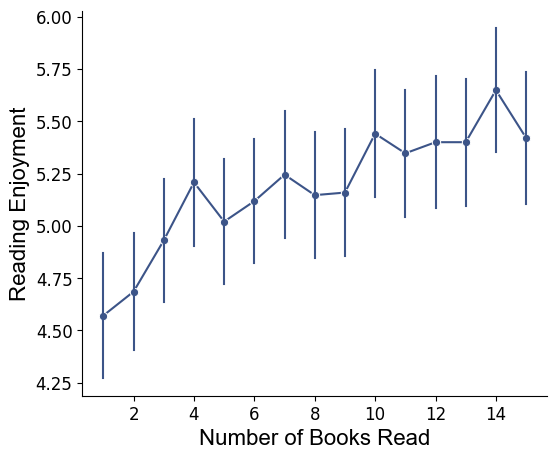

In [5]:
from matplotlib.ticker import StrMethodFormatter
fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(data=behavioral_df,
             x="choice_index", 
             y="enjoyment", errorbar=("se", 2),err_style="bars",marker="o",
             markers=True,
             dashes=True, color="#3C5488FF")


ax.spines[['right', 'top']].set_visible(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.xlabel("Number of Books Read", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Reading Enjoyment", fontdict={'fontfamily': 'Arial', 'fontsize': 16})

In [6]:
r_res = pearsonr(behavioral_df.choice_index, 
                 behavioral_df.enjoyment)
print(r_res)
print(r_res.confidence_interval(confidence_level=0.99))

PearsonRResult(statistic=0.106789284840337, pvalue=8.576823650495215e-11)
ConfidenceInterval(low=0.0646004181201871, high=0.14859709096535034)


Text(0, 0.5, 'Explore Distance')

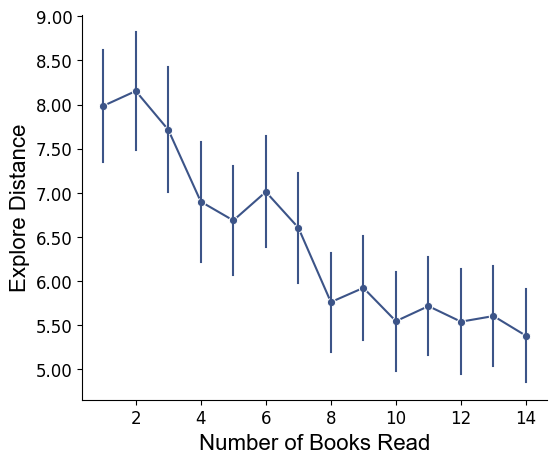

In [7]:
from matplotlib.ticker import StrMethodFormatter
fig, ax = plt.subplots(figsize=(6, 5))
sns.lineplot(data=behavioral_df,
             x="choice_index",
             y="step_size_after", errorbar=("se", 2),err_style="bars",marker="o",
             dashes=True, color="#3C5488FF")


ax.spines[['right', 'top']].set_visible(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.xlabel("Number of Books Read", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Explore Distance", fontdict={'fontfamily': 'Arial', 'fontsize': 16})

In [8]:
r_res = pearsonr(behavioral_df[~behavioral_df.step_size_after.isna()].choice_index, 
                 behavioral_df[~behavioral_df.step_size_after.isna()].step_size_after)
print(r_res)
print(r_res.confidence_interval(confidence_level=0.99))

PearsonRResult(statistic=-0.1815634626514564, pvalue=8.306460153586588e-27)
ConfidenceInterval(low=-0.2237494676668047, high=-0.1386984292075317)


Text(0, 0.5, 'Subsequent Explore Distance')

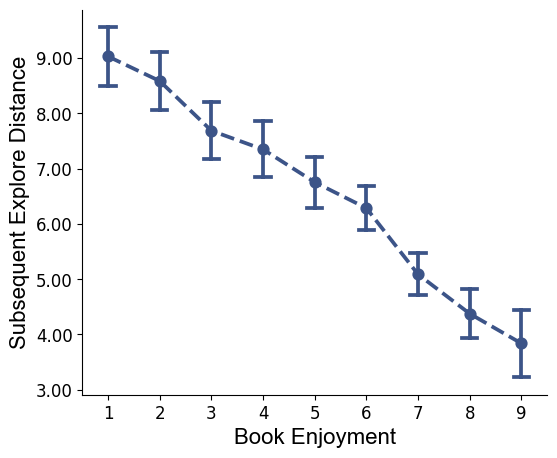

In [9]:
fig, ax = plt.subplots(figsize=(6, 5))

sns.pointplot(data=behavioral_df,
             x=behavioral_df.enjoyment.astype(int), capsize=.3,
             y="step_size_after", 
             errorbar=("se", 2),linestyle="--",
             markers="o",  color="#3C5488FF")

# ax.get_legend().remove()
ax.spines[['right', 'top']].set_visible(False)
# ax.set_xticks([1, 2, 3, 4, 5])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
plt.xlabel("Book Enjoyment", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Subsequent Explore Distance", fontdict={'fontfamily': 'Arial', 'fontsize': 16})

In [10]:
r_res = pearsonr(behavioral_df[~behavioral_df.step_size_after.isna()].enjoyment, 
                 behavioral_df[~behavioral_df.step_size_after.isna()].step_size_after)
print(r_res)
print(r_res.confidence_interval(confidence_level=0.99))

PearsonRResult(statistic=-0.32109645309921364, pvalue=4.241129302859753e-83)
ConfidenceInterval(low=-0.35998604672087814, high=-0.28109293831282495)


In [11]:
import matplotlib.patches as mpatches

In [12]:
from scipy.stats import ttest_ind

/home/jasongong/anaconda3/envs/dissertation/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jasongong/anaconda3/envs/dissertation/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


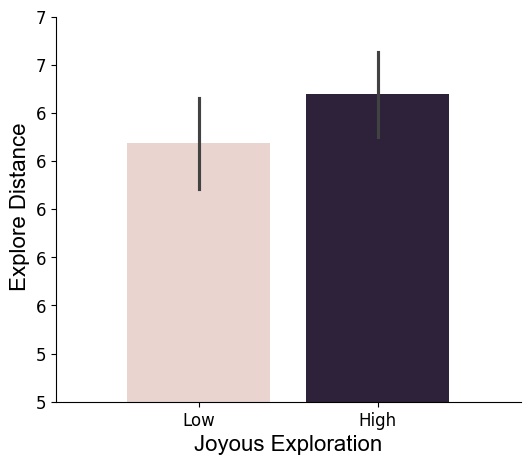

In [13]:
from matplotlib.ticker import StrMethodFormatter
fig, ax = plt.subplots(figsize=(6, 5))
behavioral_df["Joyous Exploration"] = to_quantiles(behavioral_df.curiosity_je, 2)
sns.barplot(data=behavioral_df, x="Joyous Exploration", y="step_size_after",
             hue="Joyous Exploration")


ax.spines[['right', 'top']].set_visible(False)
plt.xlim(-0.8, 1.8)
plt.ylim(5, 7)

plt.xticks(fontsize=12, ticks = [0, 1], labels=["Low", "High"])
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlabel("Joyous Exploration", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel(" Explore Distance", fontdict={'fontfamily': 'Arial', 'fontsize': 16})


handles, previous_labels = ax.get_legend_handles_labels()

ax.legend("", frameon=False)

/home/jasongong/anaconda3/envs/dissertation/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jasongong/anaconda3/envs/dissertation/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


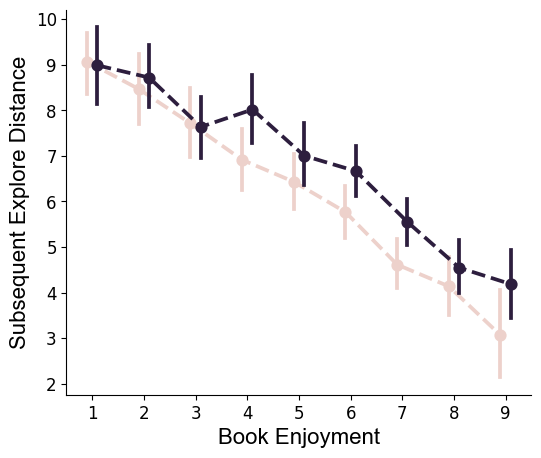

In [14]:
from matplotlib.ticker import StrMethodFormatter
fig, ax = plt.subplots(figsize=(6, 5))
behavioral_df["Joyous Exploration"] = to_quantiles(behavioral_df.curiosity_je, 2)
sns.pointplot(data=behavioral_df, x="enjoyment", y="step_size_after",linestyle="--",
             hue="Joyous Exploration", dodge=.2)

ax.spines[['right', 'top']].set_visible(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlabel("Book Enjoyment", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Subsequent Explore Distance", fontdict={'fontfamily': 'Arial', 'fontsize': 16})


handles, previous_labels = ax.get_legend_handles_labels()

ax.legend("", frameon=False)

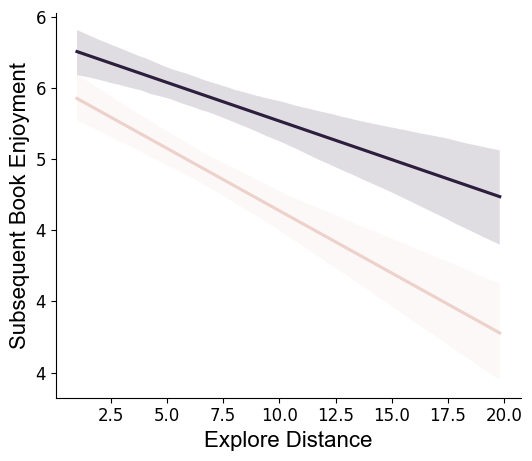

In [15]:
fig, ax = plt.subplots(figsize=(6, 5))

behavioral_df["temp"] = to_quantiles(behavioral_df.curiosity_je, 2)
sns.regplot(data=behavioral_df[behavioral_df.temp == 0.5], x="step_size_before", y="enjoyment", scatter=False, color=handles[0].get_color())
sns.regplot(data=behavioral_df[behavioral_df.temp == 1], x="step_size_before", y="enjoyment", scatter=False, color=handles[1].get_color())

ax.spines[['right', 'top']].set_visible(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlabel("Explore Distance", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Subsequent Book Enjoyment", fontdict={'fontfamily': 'Arial', 'fontsize': 16})

ax.legend("", frameon=False)

/home/jasongong/anaconda3/envs/dissertation/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/jasongong/anaconda3/envs/dissertation/lib/python3.11/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


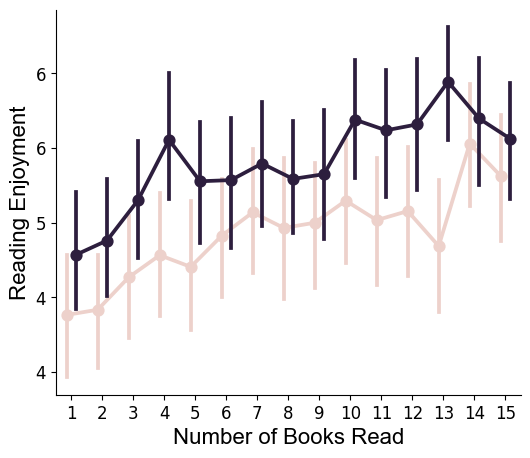

In [16]:
fig, ax = plt.subplots(figsize=(6, 5))
behavioral_df["temp"] = to_quantiles(behavioral_df.curiosity_je, 2)
sns.pointplot(data=behavioral_df, x="choice_index", y="enjoyment", 
             hue="temp", dodge=.3)

ax.spines[['right', 'top']].set_visible(False)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xlabel("Number of Books Read", fontdict={'fontfamily': 'Arial', 'fontsize': 16})
plt.ylabel("Reading Enjoyment", fontdict={'fontfamily': 'Arial', 'fontsize': 16})

ax.legend("", frameon=False)

In [26]:
from matplotlib.pyplot import figure
grid = pd.read_csv("grid_df.csv")
cmap = sns.color_palette("coolwarm", 9)

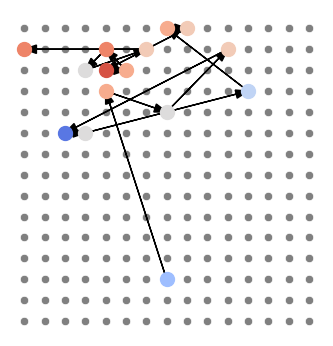

In [27]:
figure(figsize=(4, 4), dpi=100)

temp_df = behavioral_df[behavioral_df.id==behavioral_df.id.unique()[11]].merge(grid,how="left",
                                                                    left_on="choice", 
                                                                    right_on="book_index")

temp_trace = np.array(temp_df.grid_embedding_y.apply(ast.literal_eval).tolist())
sns.scatterplot(data = grid, x="x", y="y", color="grey")
  

for i in range(temp_trace.shape[0]):
    plt.plot(temp_trace[i,0],
             temp_trace[i,1], 
             'o', markersize=10, color=cmap[temp_df.enjoyment[i]-1])
for i in range(temp_trace.shape[0]-1):
    x = temp_trace[i,0]
    y = temp_trace[i,1]
    dx = temp_trace[i+1,0] - temp_trace[i,0]
    dy = temp_trace[i+1,1] - temp_trace[i,1]
    plt.arrow(x, y, dx, dy,
              head_width=0.4,
              length_includes_head=True,
              fc="black")

plt.tight_layout()  
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
plt.show()

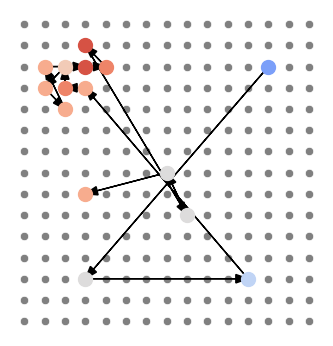

In [28]:
figure(figsize=(4, 4), dpi=100)
temp_df = behavioral_df[behavioral_df.id==behavioral_df.id.unique()[204]].merge(grid,how="left",
                                                                    left_on="choice", 
                                                                    right_on="book_index")
temp_trace = np.array(temp_df.grid_embedding_y.apply(ast.literal_eval).tolist())
sns.scatterplot(data = grid, x="x", y="y", color="grey")
  

for i in range(temp_trace.shape[0]):
    plt.plot(temp_trace[i,0],
             temp_trace[i,1], 
             'o', markersize=10, color=cmap[temp_df.enjoyment[i]-1])

for i in range(temp_trace.shape[0]-1):
    x = temp_trace[i,0]
    y = temp_trace[i,1]
    dx = temp_trace[i+1,0] - temp_trace[i,0]
    dy = temp_trace[i+1,1] - temp_trace[i,1]
    plt.arrow(x, y, dx, dy,
              head_width=0.4,
              length_includes_head=True,
             fc="black")

plt.tight_layout()  
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
plt.show()

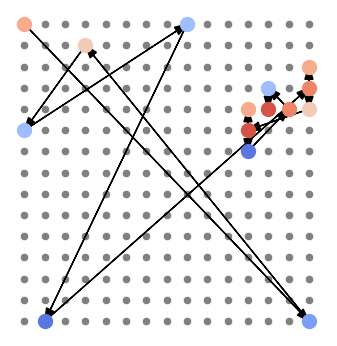

In [29]:
figure(figsize=(4, 4), dpi=100)

temp_df = behavioral_df[behavioral_df.id==behavioral_df.id.unique()[12]].merge(grid,how="left",
                                                                    left_on="choice", 
                                                                    right_on="book_index")

temp_trace = np.array(temp_df.grid_embedding_y.apply(ast.literal_eval).tolist())
sns.scatterplot(data = grid, x="x", y="y", color="grey")
  

for i in range(temp_trace.shape[0]):
    plt.plot(temp_trace[i,0],
             temp_trace[i,1], 
             'o', markersize=10, color=cmap[temp_df.enjoyment[i]-1])
    
    # plt.text(temp_trace[i,0]-0.25,
    #          temp_trace[i,1]-0.25, str(i), fontsize = 10)

for i in range(temp_trace.shape[0]-1):
    x = temp_trace[i,0]
    y = temp_trace[i,1]
    dx = temp_trace[i+1,0] - temp_trace[i,0]
    dy = temp_trace[i+1,1] - temp_trace[i,1]
    plt.arrow(x, y, dx, dy,
              head_width=0.4,
              length_includes_head=True,
              fc="black")

plt.tight_layout()  
plt.xticks([])
plt.yticks([])
plt.xlabel('')
plt.ylabel('')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False) 
plt.show()